# **Step 1. Prepare Data**

## **About Data**
* ID: Id of the user(All Unique)
* Income: Income of the user
* Age: Age of the user
* Experience: Professional experience of the user in years
* Profession: Profession of the user
* Married/Single: Whether married or not
* House_Ownership: Owned or rented or neither
* Car_Ownership: Does the person own a car
* STATE: State of residence
* CITY: City of residence
* CURRENT_JOB_YRS: Years of experience in the current job
* CURRENT_HOUSE_YRS: Number of years in the current residence\
* Risk_Flag: Defaulted on a loan(Target variable)

In [ ]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import urllib.request
from datetime import datetime, timedelta
import time
import joblib

from scipy.stats import chi2_contingency
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, mean_absolute_error
%matplotlib inline
sns.set_theme(color_codes=True, style='darkgrid', 
              palette='deep', font='sans-serif')

import warnings
warnings.filterwarnings('ignore')

In [ ]:
DOWNLOAD_URL = 'https://raw.githubusercontent.com/soncx/IS403.M22.HTCL/main/raw_data/Training%20Data.csv'
DATASET_DIR_PATH = '/content/drive/MyDrive/UIT-Learning/TERM6/PTDLKD/Final' # [directory path] để save dataset trên google drive
DATASET_PATH = os.path.join(DATASET_DIR_PATH, 'default_loan_predictor_raw.csv')

## **Retrive and save data**

In [ ]:
def fetch_data(download_url, dataset_path):
    try:
        urllib.request.urlretrieve(download_url, dataset_path)
    except:
        print(f"failed to retrive and save dataset in {dataset_path}")

In [ ]:
fetch_data(DOWNLOAD_URL, DATASET_PATH)

## **Read dataset**

In [ ]:
df = pd.read_csv(DATASET_PATH)
df_cp = df.copy()
df_cp.head()

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


# **Step 2. EDA - Exploratory Data Analysis**



In [ ]:
df_cp.drop(['Id'], axis=1, inplace=True)

In [ ]:
df_cp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Income             252000 non-null  int64 
 1   Age                252000 non-null  int64 
 2   Experience         252000 non-null  int64 
 3   Married/Single     252000 non-null  object
 4   House_Ownership    252000 non-null  object
 5   Car_Ownership      252000 non-null  object
 6   Profession         252000 non-null  object
 7   CITY               252000 non-null  object
 8   STATE              252000 non-null  object
 9   CURRENT_JOB_YRS    252000 non-null  int64 
 10  CURRENT_HOUSE_YRS  252000 non-null  int64 
 11  Risk_Flag          252000 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 23.1+ MB


In [ ]:
df_cp.describe()

,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
count,2.520000e+05,252000.000000,252000.000000,252000.000000,252000.000000,252000.000000
mean,4.997117e+06,49.954071,10.084437,6.333877,11.997794,0.123000
std,2.878311e+06,17.063855,6.002590,3.647053,1.399037,0.328438
min,1.031000e+04,21.000000,0.000000,0.000000,10.000000,0.000000
25%,2.503015e+06,35.000000,5.000000,3.000000,11.000000,0.000000
50%,5.000694e+06,50.000000,10.000000,6.000000,12.000000,0.000000
75%,7.477502e+06,65.000000,15.000000,9.000000,13.000000,0.000000
max,9.999938e+06,79.000000,20.000000,14.000000,14.000000,1.000000


## **Checking null values**

In [ ]:
df_cp.isnull().sum()

Income               0
Age                  0
Experience           0
Married/Single       0
House_Ownership      0
Car_Ownership        0
Profession           0
CITY                 0
STATE                0
CURRENT_JOB_YRS      0
CURRENT_HOUSE_YRS    0
Risk_Flag            0
dtype: int64

## **Split Numerical and Categorical features**

In [ ]:
def split_columns(df):
  num_cols = [col for col in df.columns if df[col].dtypes == 'int64']
  cat_cols = [col for col in df.columns if df[col].dtypes == 'object']
  return num_cols, cat_cols

num_cols, cat_cols = split_columns(df_cp)

In [ ]:
def print_num_cats(df, cols):
  print('Number of category in each categorial column:')
  for col in cols:
    num = len(df[col].value_counts())
    print("{0} : {1}".format(col, num))

print_num_cats(df_cp, cat_cols)

Number of category in each categorial column:
Married/Single : 2
House_Ownership : 3
Car_Ownership : 2
Profession : 51
CITY : 317
STATE : 29


## **Check data distribution**

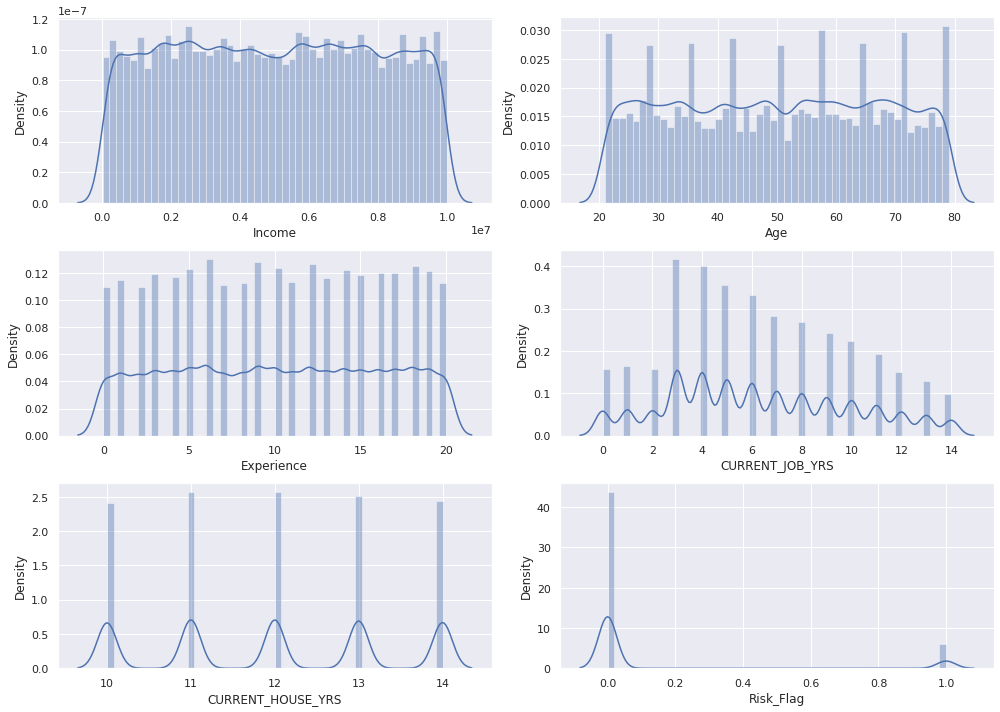

In [ ]:
fig, ax = plt.subplots(3,2,figsize=(14,10))
ax = ax.flatten()
for i,c in enumerate(num_cols):
  sns.distplot(a=df_cp[c], ax=ax[i])
fig.tight_layout()

## **Check correlation between features**

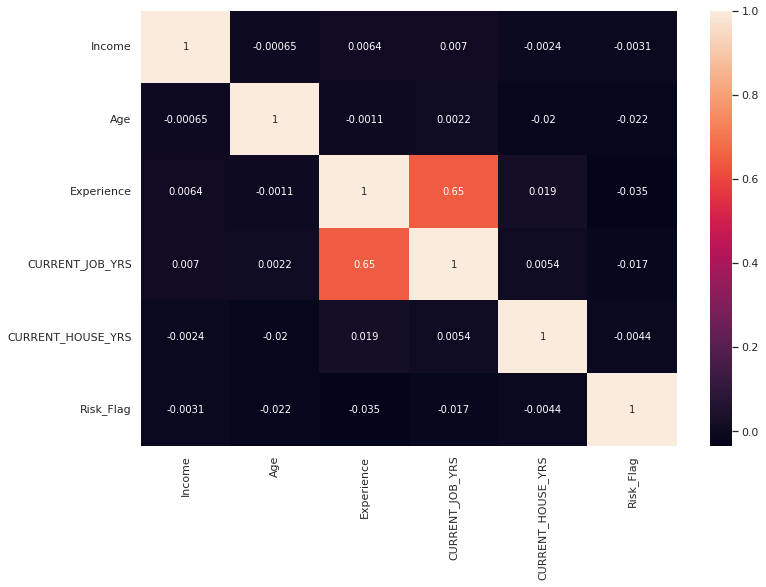

In [ ]:
plt.figure(figsize = (12,8))
ax = sns.heatmap(df_cp.corr(), annot=True)

## **Check outliers**

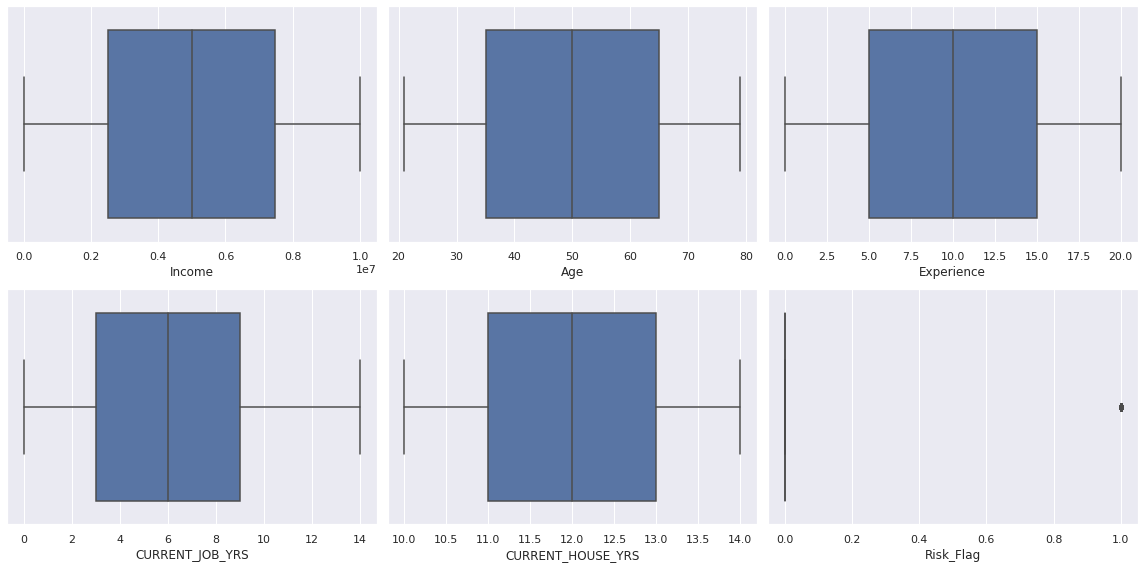

In [ ]:
fig, ax = plt.subplots(2,3,figsize=(16,8))
ax = ax.flatten()
for i,c in enumerate(num_cols):
  sns.boxplot(x=df_cp[c], ax=ax[i])
fig.tight_layout()

## **Check ratio between 0 and 1 label**

([<matplotlib.patches.Wedge at 0x7fa96b995650>,
 [Text(-2.084097871198444, 0.8479599420173779, 'Non-Defaulter'),
  Text(2.1304110963580705, -0.8668036458820442, 'Defaulter')],
 [Text(-1.157832150665802, 0.471088856676321, '87.7%'),
  Text(1.204145402289344, -0.48993249549854667, '12.3%')])

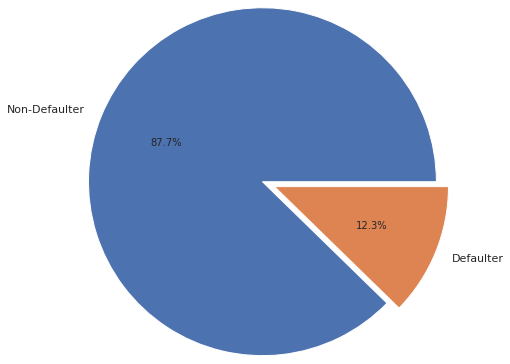

In [ ]:
r = df_cp.groupby('Risk_Flag')['Risk_Flag'].count()
plt.pie(r, explode=[0.05, 0.1], labels=['Non-Defaulter', 'Defaulter'], 
        radius=2.0, autopct='%1.1f%%')

## **Summary**


*   It's imbalanced in feature Risk_Flag (87.7% of class 0 in the dataset, while class 1 is 12.3%). 
*   There are no outliers in dataset - But we need to scale Age and Income
* Strong correlation between Experience and CURRENT_JOB_YRS. 
* Binarise or one hot encode Married/Single, Car_Ownership and House_Ownership

# **Step 3. Feature Engineering**

## **Target**

*   Convert categorical feature to numerical feature
*   Define features that affect to Label
*   Scale data to range [0,1]
*   Split Train and Test data



## **Encode categorical features**

In [ ]:
le = LabelEncoder()

def func_label_encode(data, cat_cols):
  for col in cat_cols:
    data[col] = le.fit_transform(data[col])

func_label_encode(df_cp, cat_cols)

## **Using Test to select necessary features**

### **Chi Square Test**
With a significance level of 95%, can it be said that the test feature and the decision feature are independent or not?
**Define Hypothesis:**

*   ***Null hypothesis (H0)***: Two features are independent with each other
*   ***Alternative hypothesis (H1)***: Two features are not independent with each other




In [ ]:
df_cat = df_cp[cat_cols]

best_feats = SelectKBest(chi2, k=len(cat_cols))
best_feats.fit(df_cat, df_cp["Risk_Flag"])

SelectKBest(k=6, score_func=<function chi2 at 0x7f36e7b85290>)

In [ ]:
df_chi2 = pd.DataFrame(best_feats.pvalues_, columns=['p-values'])
df_chi2['chi2-values'] = best_feats.scores_
df_chi2['feature'] = cat_cols
df_chi2.sort_values(by='p-values')

,p-values,chi2-values,feature
4,1.266794e-63,283.546791,CITY
2,6.535069e-24,101.677125,Car_Ownership
3,5.771417e-13,51.923209,Profession
5,1.661200e-05,18.542933,STATE
0,7.167547e-04,11.445289,Married/Single
1,7.283203e-04,11.415547,House_Ownership


**Select feature that have p-value < 0.05**

In [ ]:
use_feats = df_chi2[df_chi2['p-values'] <= 0.05]['feature'].tolist()

### **ANOVA F-Test**
With a significance level of 95%, can it be said that the test feature and the decision feature have the same variance?
**Define Hypothesis:**

*   ***Null hypothesis (H0)***: Two features have the same variance
*   ***Alternative hypothesis (H1)***: Two features don't have the same variance






```
https://machinelearningmastery.com/feature-selection-with-numerical-input-data/

https://towardsdatascience.com/anova-for-feature-selection-in-machine-learning-d9305e228476
```






In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

num_cols.remove('Risk_Flag')
continous_feats = df_cp[num_cols]
best_feats = SelectKBest(f_classif, k=len(num_cols))
best_feats.fit(continous_feats , df_cp["Risk_Flag"])

SelectKBest(k=5)

In [ ]:
df_anova = pd.DataFrame(best_feats.pvalues_,columns=['p-values'])
df_anova['anova-values'] = best_feats.scores_
df_anova['feature'] = num_cols
df_anova.sort_values(by='p-values')

,p-values,anova-values,feature
2,2.547563e-67,300.692307,Experience
1,6.687624e-28,119.918507,Age
3,1.813221e-17,72.348526,CURRENT_JOB_YRS
4,2.806947e-02,4.823851,CURRENT_HOUSE_YRS
0,1.207220e-01,2.407945,Income


In [ ]:
temp = df_anova[df_anova['p-values'] <= 0.05]['feature'].tolist()
use_feats = use_feats + temp

## **Data Scaling**
**Target:** Apply Data Normalization to feature [Profession, Age, CITY]

In [ ]:
# Select feature to scale
scale_cols = []
for col in use_feats:
  if len(df_cp[col].value_counts()) >= 50:
    scale_cols.append(col) 

scale_cols

['Profession', 'CITY', 'Age']

In [ ]:
# Check Standard Normal Distribution
df_cp[scale_cols].describe()

,Profession,CITY,Age
count,252000.000000,252000.000000,252000.000000
mean,25.276746,158.137675,49.954071
std,14.728537,92.201736,17.063855
min,0.000000,0.000000,21.000000
25%,13.000000,78.000000,35.000000
50%,26.000000,157.000000,50.000000
75%,38.000000,238.000000,65.000000
max,50.000000,316.000000,79.000000


**Summary:** Because these features we need to scale do not have Standard Normal Distribution, therefore we'll conduct Normalization instead of Standardization

In [ ]:
scaler = MinMaxScaler()
df_cp[scale_cols] = scaler.fit_transform(df_cp[scale_cols])

In [ ]:
# check data after scaling
df_cp[scale_cols]

,Profession,CITY,Age
0,0.66,0.794304,0.034483
1,0.86,0.718354,0.327586
2,0.94,0.025316,0.775862
3,0.86,0.170886,0.344828
4,0.22,0.936709,0.448276
...,...,...,...
251995,0.90,0.512658,0.379310
251996,0.06,0.794304,0.086207
251997,0.34,0.455696,0.431034
251998,0.54,0.737342,0.413793


In [ ]:
use_feats.append('Risk_Flag')
model_data = df_cp[use_feats].copy()
model_data.head()

,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,2,0,0.66,0.794304,13,0.034483,3,3,13,0
1,1,2,0,0.86,0.718354,14,0.327586,10,9,13,0
2,0,2,0,0.94,0.025316,12,0.775862,4,4,10,0
3,1,2,1,0.86,0.170886,17,0.344828,2,2,12,1
4,1,2,0,0.22,0.936709,22,0.448276,11,3,14,1


## **Split Train and Test data**

In [ ]:
X = model_data.drop(['Risk_Flag'],axis=1)
Y = model_data['Risk_Flag']

x_train,x_test,y_train,y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [ ]:
print(x_train.shape)
print(y_train.shape)

(201600, 10)
(201600,)


# **Step 4. Model building**

## **Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression

LR_stime = time.time()
LR_model = LogisticRegressionrandom_state=1)
LR_model.fit(x_train, y_train)
LR_y_pred = LR_model.predict(x_test)
LR_ex_time = time.time() - LR_stime

## **K Nearest Neighbors**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

KNN_stime = time.time()
KNN_model = KNeighborsClassifier(n_neighbors=5)
KNN_model.fit(x_train, y_train)
KNN_y_pred = KNN_model.predict(x_test)
KNN_ex_time = time.time() - KNN_stime

## **Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

DT_stime = time.time()
DT_model = DecisionTreeClassifier(criterion="entropy",random_state=1)
DT_model.fit(x_train, y_train)
DT_y_pred = DT_model.predict(x_test)
DT_ex_time = time.time() - DT_stime

## **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

RF_stime = time.time()
RF_model = RandomForestClassifier(n_estimators = 400, criterion = 'entropy')
RF_model.fit(x_train, y_train)
RF_y_pred = RF_model.predict(x_test)
RF_ex_time = time.time() - RF_stime

# **Step 5. Model validation**

In [ ]:
def func_valid(param1, param2, param3, param4, valid_name):
  li = [['Logistic Regression', param1], 
                     ['Decision Tree', param2],
                     ['K Nearest Neighbors', param3], 
                     ['Random Forest', param4]]
    
  df_temp = pd.DataFrame(li, 
                  columns = ['Algorithm', valid_name]).sort_values(
                      by=[valid_name], ascending=False)
  
  fig = plt.figure(figsize = (10, 6))

  plt.barh(df_temp['Algorithm'], df_temp[valid_name])
 
  plt.ylabel("Algorithm")
  plt.xlabel(valid_name)
  plt.title("Evaluation of Algorithm's " + valid_name)

  for index, val in enumerate(df_temp[valid_name]):
    plt.text(val, index, str(round(val,2)), fontweight = 'bold')

  plt.show()

## **Execution Time**

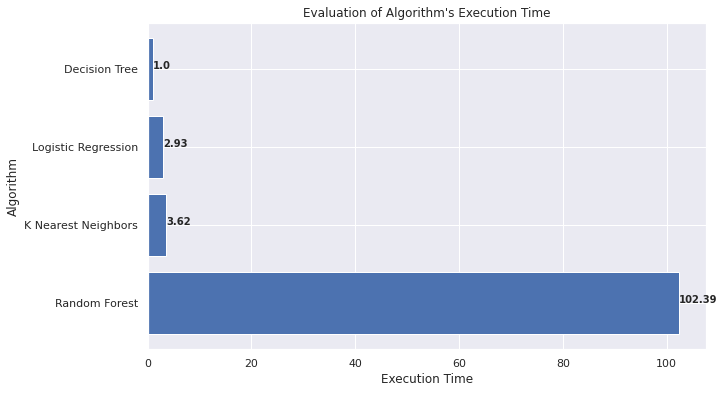

In [ ]:
func_valid(LR_ex_time, DT_ex_time, KNN_ex_time, RF_ex_time, 'Execution Time')

## **Accuracy**

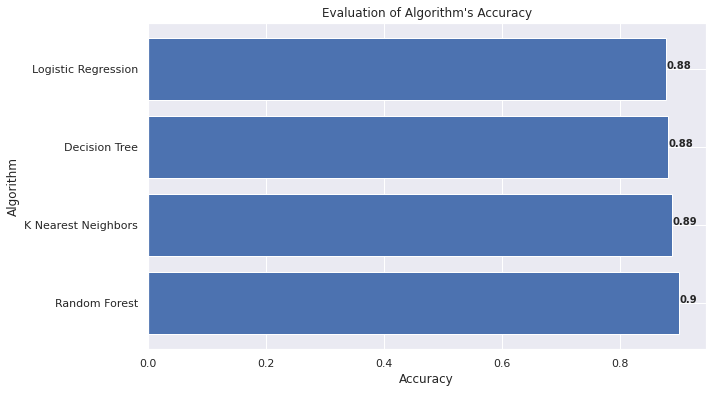

In [ ]:
LR_acc_score = accuracy_score(y_test, LR_y_pred)
DT_acc_score = accuracy_score(y_test, DT_y_pred)
KNN_acc_score = accuracy_score(y_test, KNN_y_pred)
RF_acc_score = accuracy_score(y_test, RF_y_pred)

func_valid(LR_acc_score, DT_acc_score, KNN_acc_score, RF_acc_score, "Accuracy")

## **Mean Absolute Error**

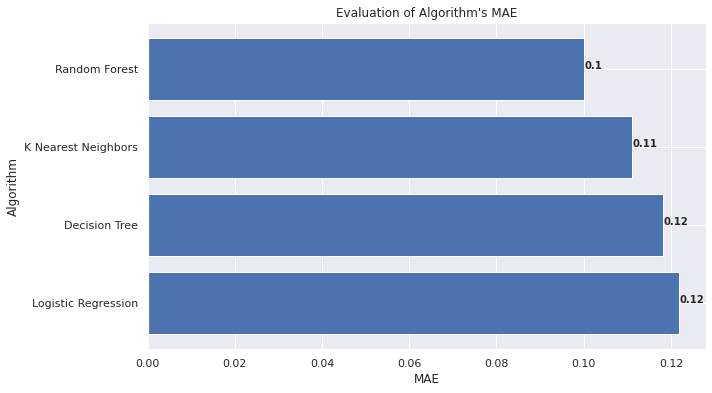

In [ ]:
LR_acc_score = mean_absolute_error(y_test, LR_y_pred)
DT_acc_score = mean_absolute_error(y_test, DT_y_pred)
KNN_acc_score = mean_absolute_error(y_test, KNN_y_pred)
RF_acc_score = mean_absolute_error(y_test, RF_y_pred)

func_valid(LR_acc_score, DT_acc_score, KNN_acc_score, RF_acc_score, "MAE")

## **Root Mean Squared Error**

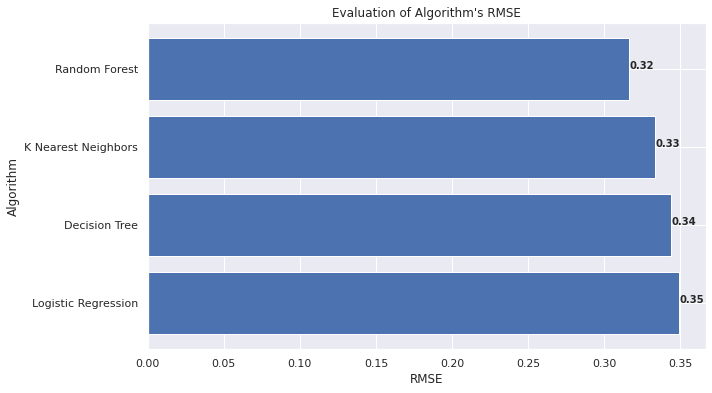

In [ ]:
LR_acc_score = mean_squared_error(y_test, LR_y_pred, squared=False)
DT_acc_score = mean_squared_error(y_test, DT_y_pred, squared=False)
KNN_acc_score = mean_squared_error(y_test, KNN_y_pred, squared=False)
RF_acc_score = mean_squared_error(y_test, RF_y_pred, squared=False)

func_valid(LR_acc_score, DT_acc_score, KNN_acc_score, RF_acc_score, "RMSE")

## **Confusion Matrix**

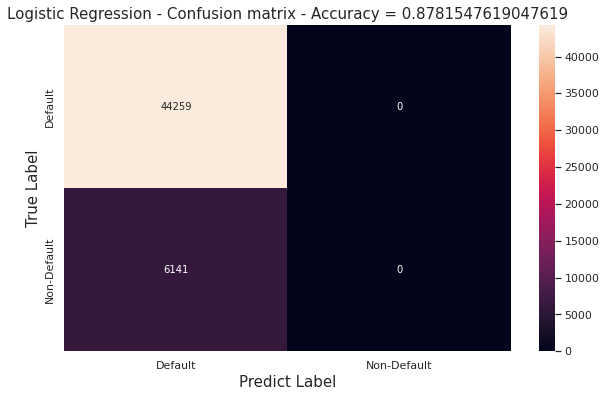

In [ ]:
LR_cm = confusion_matrix(y_test, LR_y_pred)
plt.figure(figsize=(10, 6))
plt.title("Logistic Regression - Confusion matrix - Accuracy = {0}".format(accuracy_score(y_test, LR_y_pred)), size=15)
ax = sns.heatmap(LR_cm, annot=True, fmt="g", xticklabels=["Default", "Non-Default"], yticklabels=["Default", "Non-Default"])
ax.set_ylabel("True Label", fontsize=15)
ax.set_xlabel("Predict Label", fontsize=15)
plt.show()

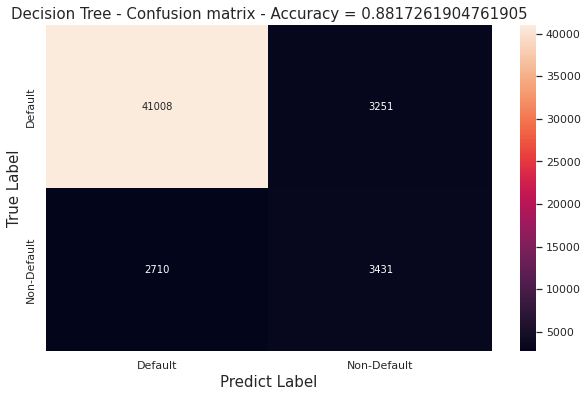

In [ ]:
dec_tree_cm = confusion_matrix(y_test, DT_y_pred)
plt.figure(figsize=(10, 6))
plt.title("Decision Tree - Confusion matrix - Accuracy = {0}".format(accuracy_score(y_test, DT_y_pred)), size=15)
ax = sns.heatmap(dec_tree_cm, annot=True, fmt="g", xticklabels=["Default", "Non-Default"], yticklabels=["Default", "Non-Default"])
ax.set_ylabel("True Label", fontsize=15)
ax.set_xlabel("Predict Label", fontsize=15)
plt.show()

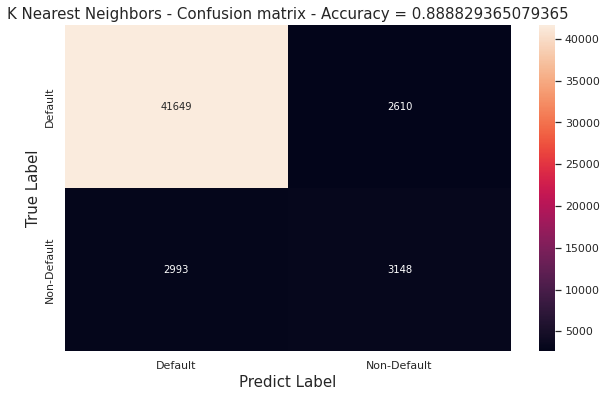

In [ ]:
knn_cm = confusion_matrix(y_test, KNN_y_pred)
plt.figure(figsize=(10, 6))
plt.title("K Nearest Neighbors - Confusion matrix - Accuracy = {0}".format(accuracy_score(y_test, KNN_y_pred)), size=15)
ax = sns.heatmap(knn_cm, annot=True, fmt="g", xticklabels=["Default", "Non-Default"], yticklabels=["Default", "Non-Default"])
ax.set_ylabel("True Label", fontsize=15)
ax.set_xlabel("Predict Label", fontsize=15)
plt.show()

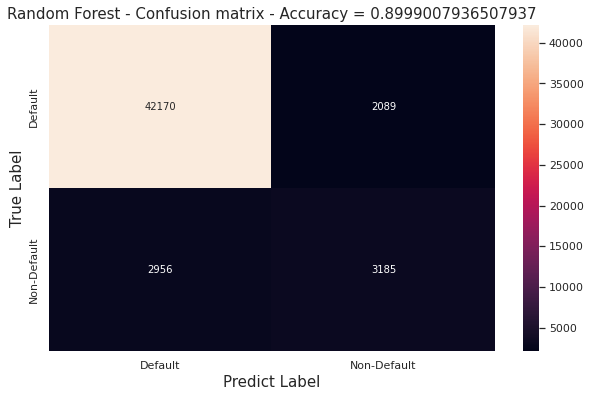

In [ ]:
rand_forest_cm = confusion_matrix(y_test, RF_y_pred)
plt.figure(figsize=(10, 6))
plt.title("Random Forest - Confusion matrix - Accuracy = {0}".format(accuracy_score(y_test, RF_y_pred)), size=15)
ax = sns.heatmap(rand_forest_cm, annot=True, fmt="g", xticklabels=["Default", "Non-Default"], yticklabels=["Default", "Non-Default"])
ax.set_ylabel("True Label", fontsize=15)
ax.set_xlabel("Predict Label", fontsize=15)
plt.show()

# **Build Application**

In [ ]:
# saving model
import pickle
pickle.dump(LR_model, open("LR_model.pkl", 'wb'))
pickle.dump(DT_model, open("DT_model.pkl", 'wb'))
pickle.dump(KNN_model, open("KNN_model.pkl", 'wb'))
pickle.dump(RF_model, open("RF_model.pkl", 'wb'))